In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from torch.distributions import Categorical, Exponential

In [1]:
from utils_ import hawkes, intensity_hawkes, plot_process, generate_hawkes, generate_mpp

In [3]:
torch.manual_seed(1)

In [91]:
def autoregressive_data(time_step = 100, num_sample = 80, num_clusters=3):
    def _alpha_n(interval_history, mu, gamma, mem_vec, m):
        """
            Input:
                interval_history: Tensor of shape num_clusters x n-1
                mu: base duration, Tensor of length num_clusters
                gamma: Tensor of length num_clusters
                mem_vec: Tensor of shape num_clusters x m
                m: number of lookback steps, Scalar
            Output:
                alpha_n: Tensor of shape num_clusters
        """
        _, _, history_size = interval_history.shape
        window_size = min(m, history_size)
        past_effects = interval_history[:,:,-window_size:]*mem_vec[:,-window_size:]
        inverse_alpha = mu + gamma * past_effects.sum(dim=-1)
        return torch.div(1, inverse_alpha)
    
    num_clusters = 3
    
    # effect of previous intervals
    m = 5
    
    # for each cluster, we have different
    # base_mu, gamma, and memory_vector
    vals_base_mu = 1+torch.rand(num_clusters)
    vals_gamma = torch.rand(num_clusters)
    mem_vec = torch.rand(num_clusters, m)
    
    
    interval_history = torch.zeros(num_sample, num_clusters, 1)
    # for each time, get alpha and using it compute
    # the duration of the interval.
    # Here the intervals are distributed according to the
    # exponential distribution with rate = alpha

    for n in range(time_step):
        rate = _alpha_n(interval_history, vals_base_mu, vals_gamma, mem_vec, m)
        interval_dist = Exponential(rate=rate)
        duration_n = interval_dist.sample()
        interval_history = torch.cat([interval_history, duration_n.view(num_sample, -1, 1)], dim=-1)
    
    # first interval was all zeros for convenience
    interval_history = interval_history[:,:,1:]
    # combine the data from different clusters into one
    interval_history = interval_history.view(-1, time_step)
    # shape = T x N
    interval_history = interval_history.transpose(0,1)
    timeseries = interval_history.cumsum(0)
    # shape = T x N x 2
    t = torch.stack([timeseries, interval_history], dim=-1)
    return t

In [92]:
autoregressive_data().shape

torch.Size([100, 240, 2])

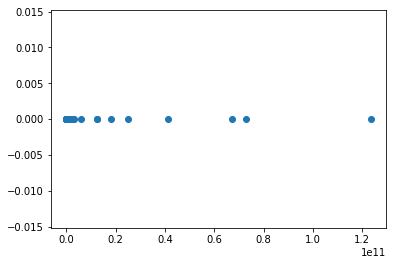

(100,)


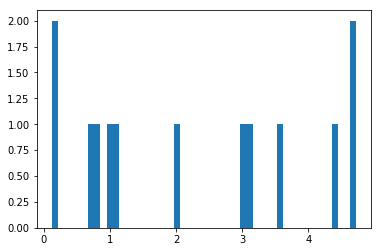

In [87]:
def plot_process(timeseries, intervals=False):
    """
        Input:
            timeseries: Tensor of shape T x N
    """
#     if intervals:
#         timeseries = timeseries.cumsum(dim=0)
    
    
    history = np.array(timeseries[:,1])
#     time = np.linspace(0, history[-1], 1000)
#     intensities = [intensity_hawkes(t, history) for t in time]
#     plt.plot(time, intensities)
    plt.scatter(history, np.zeros_like(history))
    plt.show()
    print(history.shape)
    plt.hist(history[history<5], bins=50)
    
plot_process(autoregressive_data(), intervals=True)

In [83]:
num_clusters = 3
vals_mu = torch.rand(num_clusters)
prob_mu = torch.rand(num_clusters)
vals_mu

tensor([0.0892, 0.5514, 0.9913])

In [4]:
prob_mu /= prob_mu.sum()
mu_dist = Categorical(probs=prob_mu)
mu_dist.sample()
vals_mu[mu_dist.sample()]

tensor(0.6788)

In [6]:
generate_mpp()[0]['x']

tensor([[[-1.0968e+00,  1.9381e+00,  3.0484e-01,  ..., -8.9146e-01,
           8.6334e-01,  7.8218e-01],
         [-5.8750e-01, -1.9692e+00, -6.8172e-01,  ...,  1.3253e+00,
          -1.0980e+00,  1.7116e+00],
         [-1.3752e+00, -1.3994e+00,  1.0891e+00,  ...,  2.1437e-01,
          -1.5731e+00,  1.1374e+00],
         ...,
         [-1.9187e+00,  1.1461e+00, -1.5353e+00,  ..., -7.5408e-01,
          -4.7184e-02, -5.6133e-01],
         [ 1.0332e+00, -4.3472e-01,  3.1378e-01,  ..., -1.1160e+00,
           1.2970e+00, -2.4168e+00],
         [-2.2053e+00, -3.9163e-01,  3.4941e-01,  ...,  6.2798e-01,
          -1.2972e+00, -3.5974e-02]],

        [[-1.2021e+00,  5.0608e-01, -3.9142e-01,  ..., -4.4091e-01,
          -2.6486e-01, -2.8753e+00],
         [ 6.6529e-01, -1.4317e+00,  3.1774e-01,  ...,  5.0915e-01,
           1.3670e+00, -2.0537e+00],
         [ 1.1055e+00,  1.0706e+00,  1.1075e+00,  ...,  5.6959e-01,
           2.6731e-01, -9.5668e-02],
         ...,
         [ 4.3031e-01, -8

In [6]:
timeseries = hawkes(intensity_hawkes)

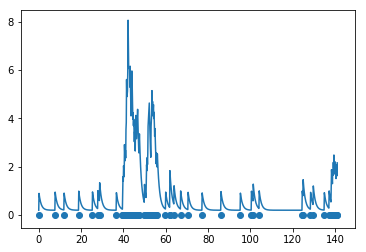

In [7]:
plot_process(timeseries)

In [6]:
data = generate_hawkes(time_step = 100, num_sample = 80, num_clusters=3)

In [7]:
intervals = data[:,:,1].view(-1)

In [36]:
intervals[intervals<0.3] = intervals[intervals<0.3]*10

(array([1060.,  870.,  736.,  606.,  493.,  433.,  355.,  334.,  269.,
         232.,  208.,  178.,  161.,  167.,  154.,  125.,   93.,   85.,
          91.,   84.,   81.,   57.,   70.,   55., 1003.]),
 array([0.10004425, 0.19604248, 0.2920407 , 0.38803893, 0.48403716,
        0.5800354 , 0.6760336 , 0.77203184, 0.8680301 , 0.9640283 ,
        1.0600265 , 1.1560248 , 1.252023  , 1.3480213 , 1.4440194 ,
        1.5400177 , 1.6360159 , 1.7320142 , 1.8280123 , 1.9240106 ,
        2.0200088 , 2.116007  , 2.2120054 , 2.3080034 , 2.4040017 ,
        2.5       ], dtype=float32),
 <a list of 25 Patch objects>)

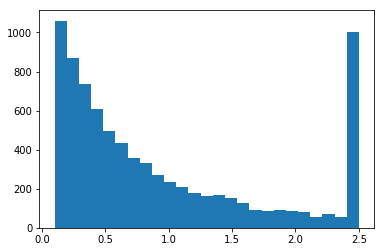

In [10]:
# plt.hist(intervals[(intervals <= 2.5) and (intervals <= 2.5)])
plt.hist(intervals, bins=25)
# plt.hist(intervals[intervals <= 2.5], bins=25)
# plt.hist(intervals.clamp(0.1, 2.5), bins=25, alpha=0.5)

In [20]:
data[:5,0]

tensor([[0.0039, 0.0039],
        [0.2027, 0.1988],
        [0.4765, 0.2737],
        [2.1655, 1.6891],
        [2.2276, 0.0620]])